In [1]:
import pandas as pd

# Load the data
data1 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")
data2 = pd.read_csv("Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
data3 = pd.read_csv("1429_1.csv", low_memory=False)

# Display basic information about the datasets
print("Data 1 Info:")
data1.info()
print("\nData 2 Info:")
data2.info()
print("\nData 3 Info:")
data3.info()


Data 1 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16

How do we preprocess the data for sentiment classification?

In [3]:
# Combine the dataframes
combined_data = pd.concat([data1, data2, data3], ignore_index=True)

# Select relevant columns for classification
classification_data = combined_data[['reviews.text', 'reviews.rating']]

# Drop missing values
classification_data = classification_data.dropna()

# Create binary sentiment labels (positive: 1, negative: 0)
classification_data['sentiment'] = classification_data['reviews.rating'] > 3

# Display the first few rows of the preprocessed data
print("Preprocessed Classification Data:")
print(classification_data.head())


Preprocessed Classification Data:
                                        reviews.text  reviews.rating  \
0  I order 3 of them and one of the item is bad q...             3.0   
1  Bulk is always the less expensive way to go fo...             4.0   
2  Well they are not Duracell but for the price i...             5.0   
3  Seem to work as well as name brand batteries a...             5.0   
4  These batteries are very long lasting the pric...             5.0   

   sentiment  
0      False  
1       True  
2       True  
3       True  
4       True  


How can we vectorize the text data for sentiment classification?

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    classification_data['reviews.text'], 
    classification_data['sentiment'], 
    test_size=0.2, random_state=42
)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Display the shape of the vectorized data
print("Vectorized Data Shape:")
print("Train:", X_train_vectorized.shape)
print("Test:", X_test_vectorized.shape)


Vectorized Data Shape:
Train: (54366, 5000)
Test: (13592, 5000)


How can we perform Ridge classification on the vectorized data?

In [7]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the Ridge Classifier
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_vectorized, y_train)

# Make predictions on the test set
y_pred = ridge_classifier.predict(X_test_vectorized)

# Calculate and display the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Ridge Classification Accuracy:", accuracy)


Ridge Classification Accuracy: 0.9396703943496174


How can we perform Ridge regression on the numeric data?

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Select relevant columns for regression
regression_data = combined_data[['reviews.rating', 'reviews.numHelpful']]

# Drop missing values
regression_data = regression_data.dropna()

# Split the data into training and testing sets
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    regression_data['reviews.numHelpful'], 
    regression_data['reviews.rating'], 
    test_size=0.2, random_state=42
)

# Reshape data for regression
X_reg_train = X_reg_train.values.reshape(-1, 1)
X_reg_test = X_reg_test.values.reshape(-1, 1)

# Initialize and train the Ridge Regression model
ridge_regression = Ridge(alpha=1.0)
ridge_regression.fit(X_reg_train, y_reg_train)

# Make predictions on the test set
y_reg_pred = ridge_regression.predict(X_reg_test)

# Calculate and display the mean squared error
mse = mean_squared_error(y_reg_test, y_reg_pred)
print("Ridge Regression Mean Squared Error:", mse)


Ridge Regression Mean Squared Error: 0.5494846953221221


How can we perform hyperparameter tuning for the Ridge Classifier to improve classification performance?

In [11]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {'alpha': [0.1, 1.0, 10.0]}

# Initialize Ridge Classifier
ridge_classifier = RidgeClassifier()

# Perform Grid Search Cross-Validation
grid_search = GridSearchCV(ridge_classifier, param_grid, cv=5)
grid_search.fit(X_train_vectorized, y_train)

# Display the best hyperparameters
print("Best Hyperparameters for Ridge Classifier:", grid_search.best_params_)

# Evaluate the model with the best hyperparameters
best_ridge_classifier = grid_search.best_estimator_
y_pred_tuned = best_ridge_classifier.predict(X_test_vectorized)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print("Tuned Ridge Classification Accuracy:", accuracy_tuned)


Best Hyperparameters for Ridge Classifier: {'alpha': 0.1}
Tuned Ridge Classification Accuracy: 0.9400382577987051


How can we analyze the feature importance in Ridge Regression?

In [13]:
# Display the coefficients and corresponding feature names
coefs = ridge_regression.coef_
feature_names = ['reviews.numHelpful']
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs.flatten()})
print("Ridge Regression Coefficients:")
print(coefficients_df)


Ridge Regression Coefficients:
              Feature  Coefficient
0  reviews.numHelpful    -0.002579


How can we use the trained Ridge Classifier to predict the sentiment of new reviews?

In [15]:
# Example: Predict sentiment for a new review
new_review = ["This product is fantastic! I highly recommend it."]
new_review_vectorized = vectorizer.transform(new_review)
predicted_sentiment = best_ridge_classifier.predict(new_review_vectorized)[0]

sentiment_label = "Positive" if predicted_sentiment == 1 else "Negative"
print("Predicted Sentiment for the New Review:", sentiment_label)


Predicted Sentiment for the New Review: Positive


How can we handle imbalanced classes in the sentiment classification task?

In [17]:
from sklearn.utils import resample

# Upsample the minority class (negative sentiment)
negative_class = classification_data[classification_data['sentiment'] == 0]
positive_class = classification_data[classification_data['sentiment'] == 1]

negative_class_upsampled = resample(negative_class, replace=True, n_samples=len(positive_class), random_state=42)

# Combine the upsampled negative class with the positive class
upsampled_data = pd.concat([positive_class, negative_class_upsampled])

# Display the distribution of the upsampled classes
print("Upsampled Sentiment Distribution:")
print(upsampled_data['sentiment'].value_counts())


Upsampled Sentiment Distribution:
sentiment
True     62546
False    62546
Name: count, dtype: int64


How can we perform cross-validation for Ridge Regression to get more robust performance metrics?

In [19]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation for Ridge Regression
cv_scores = cross_val_score(ridge_regression, X_reg_train, y_reg_train, cv=5, scoring='neg_mean_squared_error')

# Display the cross-validation scores
print("Cross-Validation Scores for Ridge Regression:")
print(cv_scores)

# Calculate and display the mean squared error from cross-validation
cv_mse = -cv_scores.mean()
print("Mean Squared Error from Cross-Validation:", cv_mse)


Cross-Validation Scores for Ridge Regression:
[-0.53285742 -0.52894242 -0.56729836 -0.53239883 -0.52633099]
Mean Squared Error from Cross-Validation: 0.5375656054302594


How can we obtain probabilistic predictions from the Ridge Classifier?

In [21]:
import numpy as np
# Get probability estimates for each class
probabilities = best_ridge_classifier.decision_function(X_test_vectorized)

# Convert decision function values to probabilities using the logistic function
probabilities = 1 / (1 + np.exp(-probabilities))

# Display the predicted probabilities for the first few examples
print("Predicted Probabilities for Ridge Classification:")
print(probabilities[:5])


Predicted Probabilities for Ridge Classification:
[0.7327548  0.71836374 0.66021243 0.68681383 0.78742276]


How does the choice of regularization strength (alpha) impact the Ridge Regression model?

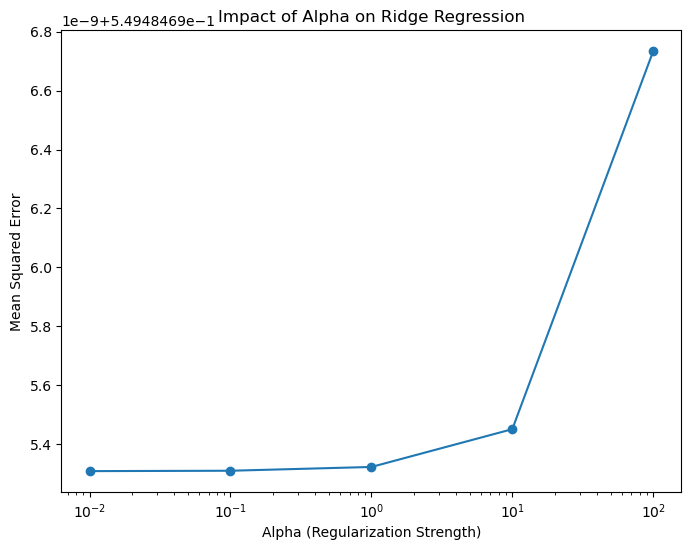

In [23]:
import matplotlib.pyplot as plt

# Evaluate Ridge Regression for different alpha values
alpha_values = [0.01, 0.1, 1, 10, 100]
mse_values = []

for alpha in alpha_values:
    ridge_regression = Ridge(alpha=alpha)
    ridge_regression.fit(X_reg_train, y_reg_train)
    y_reg_pred = ridge_regression.predict(X_reg_test)
    mse = mean_squared_error(y_reg_test, y_reg_pred)
    mse_values.append(mse)

# Plot the impact of alpha on Mean Squared Error
plt.figure(figsize=(8, 6))
plt.plot(alpha_values, mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Squared Error')
plt.title('Impact of Alpha on Ridge Regression')
plt.show()


Is feature scaling necessary for Ridge Regression, and how can it be applied?

In [26]:
from sklearn.preprocessing import StandardScaler

# Example: Apply feature scaling to numeric features
numeric_features = ['reviews.numHelpful']
scaler = StandardScaler()

# Fit and transform the training set
X_reg_train_scaled = scaler.fit_transform(X_reg_train)

# Transform the test set using the same scaler
X_reg_test_scaled = scaler.transform(X_reg_test)

# Initialize and train the Ridge Regression model with scaled features
ridge_regression_scaled = Ridge(alpha=1.0)
ridge_regression_scaled.fit(X_reg_train_scaled, y_reg_train)

# Make predictions on the scaled test set
y_reg_pred_scaled = ridge_regression_scaled.predict(X_reg_test_scaled)

# Calculate and display the mean squared error
mse_scaled = mean_squared_error(y_reg_test, y_reg_pred_scaled)
print("Ridge Regression with Scaled Features Mean Squared Error:", mse_scaled)


Ridge Regression with Scaled Features Mean Squared Error: 0.5494846973326415


How can we interpret the coefficients and features in Ridge Regression?

In [28]:
# Display the coefficients and corresponding feature names with standardized values
coefs_scaled = ridge_regression_scaled.coef_
coefficients_df_scaled = pd.DataFrame({'Feature': numeric_features, 'Coefficient': coefs_scaled.flatten()})
print("Ridge Regression Coefficients with Scaled Features:")
print(coefficients_df_scaled)


Ridge Regression Coefficients with Scaled Features:
              Feature  Coefficient
0  reviews.numHelpful    -0.030725


What are some advanced metrics for evaluating sentiment classification performance?

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_tuned))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_tuned))


Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.34      0.47      1059
        True       0.95      0.99      0.97     12533

    accuracy                           0.94     13592
   macro avg       0.85      0.67      0.72     13592
weighted avg       0.93      0.94      0.93     13592


Confusion Matrix:
[[  365   694]
 [  121 12412]]


How can we perform exploratory data analysis for sentiment analysis?

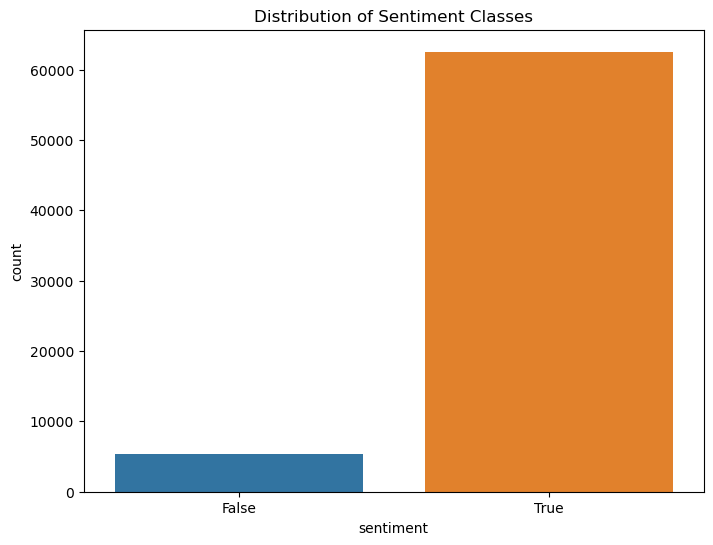

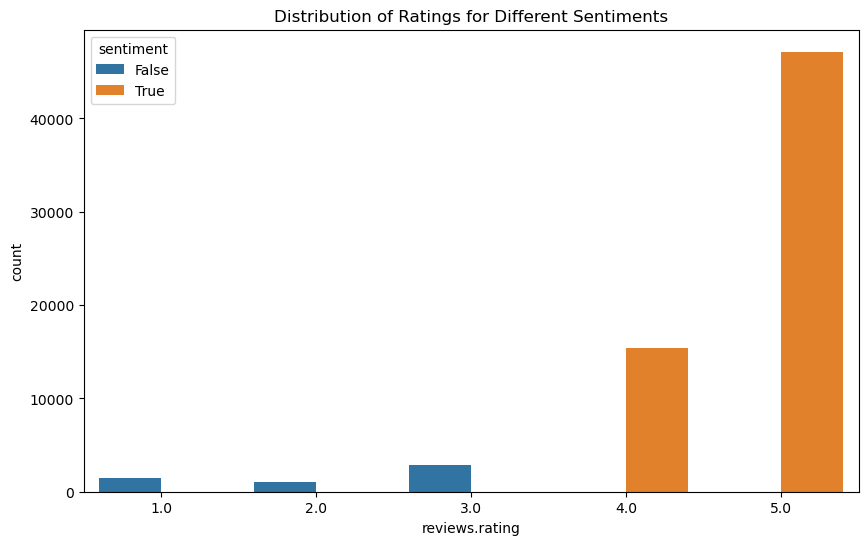

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of sentiment classes
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=classification_data)
plt.title('Distribution of Sentiment Classes')
plt.show()

# Distribution of ratings for different sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x='reviews.rating', hue='sentiment', data=classification_data)
plt.title('Distribution of Ratings for Different Sentiments')
plt.show()


How can we create word clouds for positive and negative sentiments?

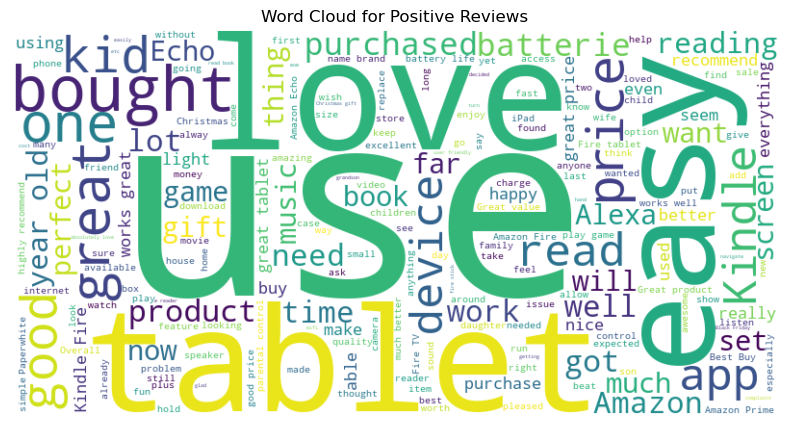

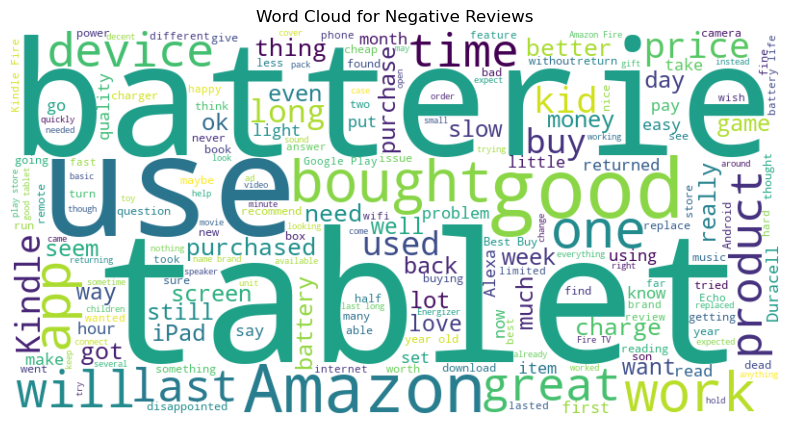

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a WordCloud for positive reviews
positive_reviews = classification_data[classification_data['sentiment'] == 1]['reviews.text'].str.cat(sep=' ')
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

# Display the WordCloud for positive reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Create a WordCloud for negative reviews
negative_reviews = classification_data[classification_data['sentiment'] == 0]['reviews.text'].str.cat(sep=' ')
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

# Display the WordCloud for negative reviews
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


How can we interpret word importance in sentiment analysis?

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model to interpret feature importance
vectorizer_interpret = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_vectorized_interpret = vectorizer_interpret.fit_transform(X_train)

rf_interpret = RandomForestClassifier(n_estimators=100, random_state=42)
rf_interpret.fit(X_train_vectorized_interpret, y_train)

# Get feature importance from the trained Random Forest model
feature_importance = pd.DataFrame({
    'Feature': vectorizer_interpret.get_feature_names_out(),
    'Importance': rf_interpret.feature_importances_
})

# Display the top words that contribute to sentiment
top_words = feature_importance.sort_values(by='Importance', ascending=False).head(10)
print("Top Words Contributing to Sentiment:")
print(top_words)


Top Words Contributing to Sentiment:
        Feature  Importance
2007      great    0.012741
1352        don    0.012581
4064       slow    0.011041
3731   returned    0.010683
3017         ok    0.010233
1171       dead    0.009982
2655       long    0.009541
1964       good    0.008105
501   batteries    0.007847
3732  returning    0.007284


How can we visualize the word frequencies in positive and negative reviews?

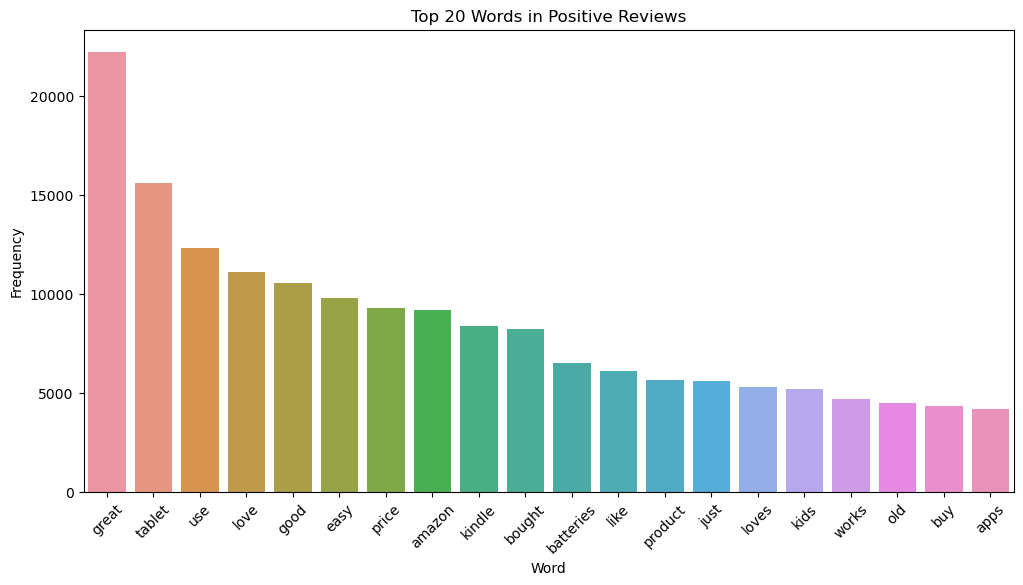

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a CountVectorizer for positive reviews
positive_reviews = classification_data[classification_data['sentiment'] == 1]['reviews.text']
vectorizer_pos = CountVectorizer(max_features=100, stop_words='english')
X_pos = vectorizer_pos.fit_transform(positive_reviews)

# Get feature names and their frequencies
feature_names_pos = vectorizer_pos.get_feature_names_out()
word_frequencies_pos = X_pos.sum(axis=0).A1

# Create a DataFrame for positive word frequencies
pos_word_frequencies_df = pd.DataFrame({'Word': feature_names_pos, 'Frequency': word_frequencies_pos})

# Sort the DataFrame by frequency
pos_word_frequencies_df = pos_word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Plot the top 20 words in positive reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=pos_word_frequencies_df.head(20))
plt.title('Top 20 Words in Positive Reviews')
plt.xticks(rotation=45)
plt.show()


How can we visualize the word frequencies in negative reviews?

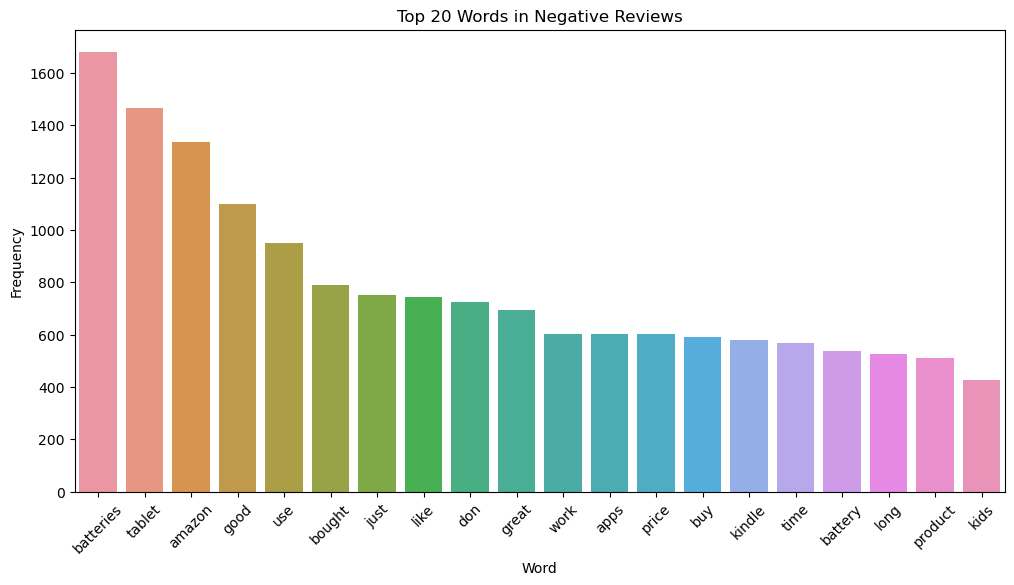

In [41]:
# Create a CountVectorizer for negative reviews
negative_reviews = classification_data[classification_data['sentiment'] == 0]['reviews.text']
vectorizer_neg = CountVectorizer(max_features=100, stop_words='english')
X_neg = vectorizer_neg.fit_transform(negative_reviews)

# Get feature names and their frequencies
feature_names_neg = vectorizer_neg.get_feature_names_out()
word_frequencies_neg = X_neg.sum(axis=0).A1

# Create a DataFrame for negative word frequencies
neg_word_frequencies_df = pd.DataFrame({'Word': feature_names_neg, 'Frequency': word_frequencies_neg})

# Sort the DataFrame by frequency
neg_word_frequencies_df = neg_word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Plot the top 20 words in negative reviews
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=neg_word_frequencies_df.head(20))
plt.title('Top 20 Words in Negative Reviews')
plt.xticks(rotation=45)
plt.show()


How can we visualize the distribution of review ratings?

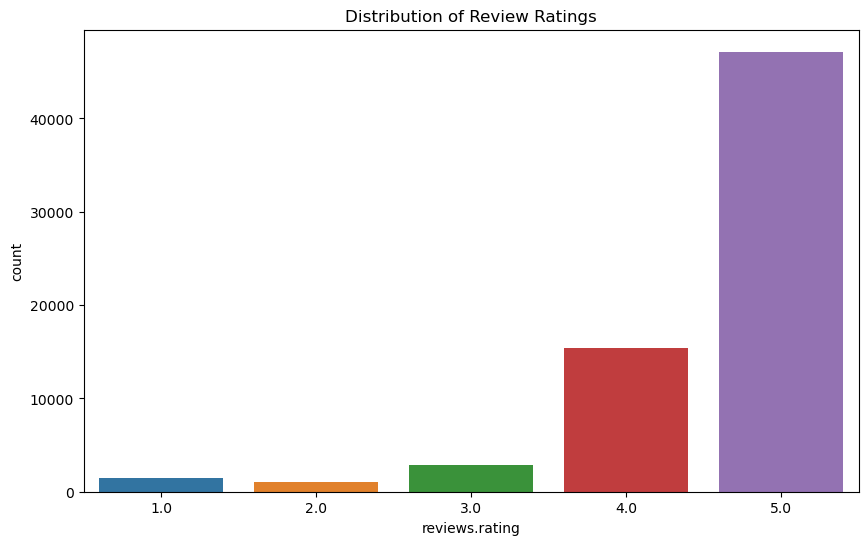

In [43]:
# Plot the distribution of review ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='reviews.rating', data=combined_data)
plt.title('Distribution of Review Ratings')
plt.show()


How can we visualize correlations between different numeric variables in the dataset?

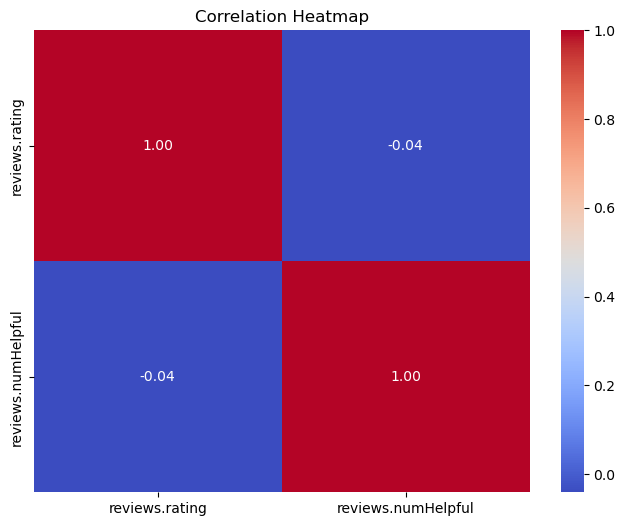

In [48]:
# Select numeric variables for correlation analysis
numeric_variables = ['reviews.rating', 'reviews.numHelpful']

# Plot a heatmap of correlations
plt.figure(figsize=(8, 6))
correlation_matrix = combined_data[numeric_variables].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


How can we visualize the relationship between user ratings and the helpfulness of reviews?

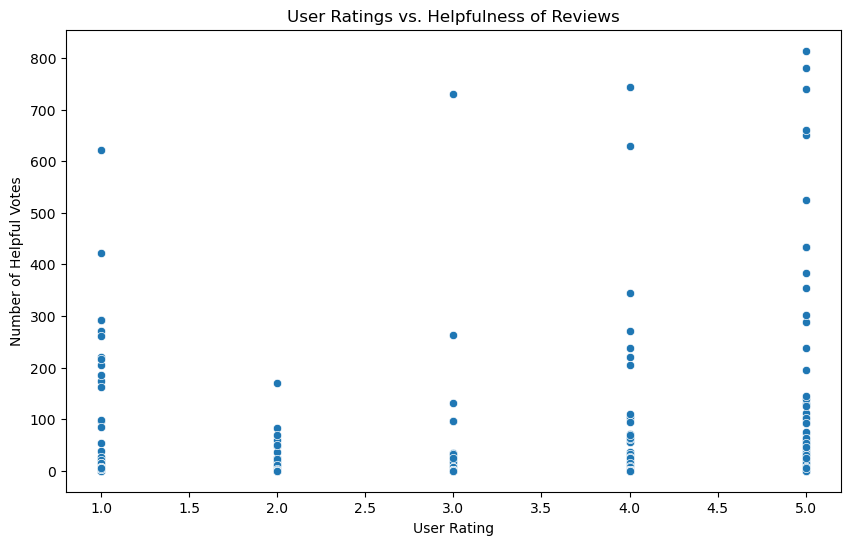

In [73]:
# Scatter plot of user ratings vs. helpfulness of reviews
plt.figure(figsize=(10, 6))
sns.scatterplot(x='reviews.rating', y='reviews.numHelpful', data=combined_data)
plt.title('User Ratings vs. Helpfulness of Reviews')
plt.xlabel('User Rating')
plt.ylabel('Number of Helpful Votes')
plt.show()
